In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

df = pd.read_csv("synthetic_incident_rca_dataset.csv")

In [2]:
# Vectorize RCA text using TF-IDF

rca_texts = df["rca_summary"].astype(str).tolist()

# Create TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(rca_texts)

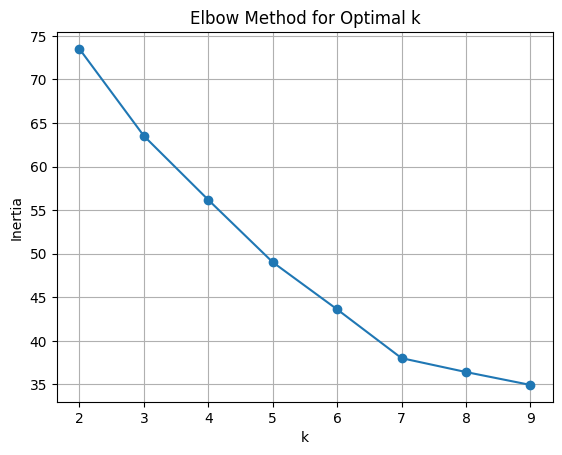

In [3]:
# Determine optimal clusters (Optional - Elbow Method)

inertia = []
K = range(2, 10)

for k in K:
    km= KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertia.append(km.inertia_)

# Plot Elbow Curve
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [4]:
# Apply KMeans Clustering
k = 5
kmeans = KMeans(n_clusters=k, random_state=12, n_init=10)
df['rca_cluster'] = kmeans.fit_predict(X)

In [5]:
# Extract Top Ketwords Per cluster

def get_top_keywords(kmeans_model, vectorizer, n_terms=5):
    keywords = {}
    terms = vectorizer.get_feature_names_out()
    for i, centroid in enumerate(kmeans_model.cluster_centers_):
        top_terms = centroid.argsort()[-n_terms:][::-1]
        keywords[i] = [terms[i] for i in top_terms]
    return keywords

top_keywords = get_top_keywords(kmeans, vectorizer)

# Show top keywords for each cluster
for cluster, words in top_keywords.items():
    print(f"Cluster {cluster}: {', '.join(words)}")

Cluster 0: service, operation, faced, database, network
Cluster 1: deployment, threshold, exceeded, caused, backend
Cluster 2: module, multiple, impacted, failure, clients
Cluster 3: issue, intermittent, layer, caused, timeout
Cluster 4: crashed, node, database, bad, config


In [6]:
# Sample Query:View RCA Summaries by Cluster

# Example: View 3 samples from Cluster 2
df[df['rca_cluster'] == 2]['rca_summary'].head(3)

8     high I/O failure impacted multiple clients in ...
14    latency spikes failure impacted multiple clien...
16    high I/O failure impacted multiple clients in ...
Name: rca_summary, dtype: object

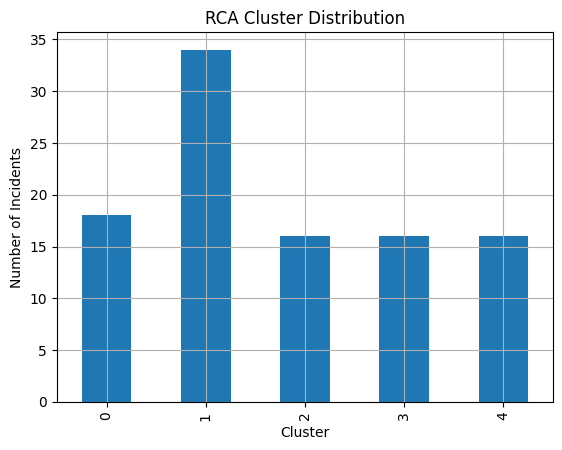

In [7]:
# Optional - View cluster distribution

df['rca_cluster'].value_counts().sort_index().plot(kind='bar', title='RCA Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.show()

In [8]:
# Query Examples for Analysis

# Average TTX by cluster
df.groupby('rca_cluster')[['ttd', 'ttk', 'ttm', 'ttc']].mean()

# Top applications involved in Cluster 0
df[df['rca_cluster'] == 0]['app_name'].value_counts().head(5)

# Incidents with long mitigation time (>60 mins) in Cluster 3
df[(df['rca_cluster'] == 3) & (df['ttm'] > 60)][['incident_id', 'rca_summary', 'ttm']]

,incident_id,rca_summary,ttm
0,61ec7ed0-169f-42d7-b7fb-c620bc4ac9b2,Intermittent issue caused by network timeout i...,67
7,953149f5-06fd-4f1d-9223-757a69dbf8d2,Intermittent issue caused by network timeout i...,62
10,8114705c-ac60-4984-9e73-faf9873f6914,Intermittent issue caused by network timeout i...,69
19,196fdd43-d87c-4627-a186-565eaad72754,Intermittent issue caused by latency spikes in...,75
23,5555ccb4-cf65-4020-a773-8e1e197b2948,Intermittent issue caused by cache eviction in...,63
26,c07a8796-34ca-45f9-a2c0-c3327058b374,Intermittent issue caused by network timeout i...,87
35,88909d9d-bcb5-415b-bccd-4bac3a4d3a35,Intermittent issue caused by high I/O in datab...,84
47,9daf5078-c811-44c9-b4fb-95a319efac22,Intermittent issue caused by high I/O in front...,85
57,b67d7346-7cd9-4b45-973d-86343c37579b,Intermittent issue caused by latency spikes in...,75


In [9]:
# Wrapped up query

def query_rca_by_text(input_query, top_n=5):
    query_vec = vectorizer.transform([input_query])
    similarities = cosine_similarity(query_vec, X).flatten()
    top_indices = similarities.argsort()[::-1][:top_n]
    return df.iloc[top_indices][['incident_id', 'rca_summary', 'rca_cluster']]

# Example query
query_rca_by_text("latency issue in frontend")


,incident_id,rca_summary,rca_cluster
19,196fdd43-d87c-4627-a186-565eaad72754,Intermittent issue caused by latency spikes in...,3
47,9daf5078-c811-44c9-b4fb-95a319efac22,Intermittent issue caused by high I/O in front...,3
12,e7e99a35-f3b3-4c39-931d-de9d01e6b5d1,Intermittent issue caused by cache eviction in...,3
53,028bdf88-8c9f-44c1-96bb-ca5e011d0ee9,Intermittent issue caused by missing patch in ...,3
57,b67d7346-7cd9-4b45-973d-86343c37579b,Intermittent issue caused by latency spikes in...,3
